In [1]:
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../../RKLM_Python/')
# Path to output files
sys.path.append('../')

import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle

# For which test case do we plot?
`swe` is the shallow water vortex, `euler` the Euler vortex and `rb` the rising bubble.

In [2]:
swe = False
euler = False
rb = True

# Plot format for MWR or arXiv?
MWR = True
arXiv = False

plot_oneda = False
plot_psinc = False
plot_dab = False
plot_12 = True

## For given test case, load the relevant parameters

In [3]:
global pydir
pydir = ''
# pydir = '../../%s/psinc/' %base_fn
def load(base_fn,Nx,Ny,et,Nz=None):
    global pydir
#     pydir = '../../%s/psinc/' %base_fn
    pydir = '../../%s/' %base_fn
    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    return tc, tags

if swe:
    base_fn = 'output_swe_vortex'
    Nx, Ny, Nz = 64, 1, 64
    et = 3.0
    tc, tags = load(base_fn,Nx,Ny,et,Nz)
    
    attr_labels = pt.swe_labels()
    attributes = ['rho','p2_nodes','rhou','rhow']
    obs_attrs = 'rhou_rhow'
    aux = 'wda'
    aux_ref = ''
    lbl = 'swe'
    times = np.arange(0.0,3.01,0.01)[1:]
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Nz

elif euler:
    base_fn = "output_travelling_vortex"
    Nx, Ny = 64, 64
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    attributes[1] = 'p2_nodes' if 'psinc' in pydir or plot_psinc else 'rhoY'
#     attributes[1] = 'p2_nodes' if plot_psinc else 'rhoY'
    obs_attrs = 'rhou_rhov'
    aux = 'wda_varcov_bt_ib-0'
#     aux = 'wda_fixcov_10p_ib-0'
#     aux = 'wda_varcov_artigen_ib-0'
#     aux = 'wda_artigen_ib-0'
#     aux = 'wda_p33_ib-0'
#     aux = 'wda_lconv_DET_ib-0'
#     aux = 'wda_noloc_ib-0'
    aux_ref = '_ib-0'
#     aux_ref = '_artigen_ib-0'
#     aux_ref = '_truthgen_ib-0'
#     aux_ref = '_p33_ib-0'
    
    print(pydir)
    if 'psinc' in pydir:
        print("???")
        aux = 'wda_psinc'
#         aux = 'wda_psinc_artigen_obs'
        aux_ref = '_psinc'
#         aux_ref = '_psinc_nonanalytical'
        
    lbl = 'euler'
#     times = np.arange(0.0,3.01,0.01)[1:]
    if 'psinc' in pydir or 'artigen' in aux or 'lconv' in aux or 'noloc' in aux:
        et = 10.0
        times = np.arange(0.0,10.05,0.05)[1:]
    else:
        et = 3.0
        times = np.arange(0.0,3.05,0.05)[1:]
    tc, tags = load(base_fn,Nx,Ny,et)
    
    x_axs = [-0.5,0.0,0.5]
    y_axs = [-0.5,0.0,0.5]
    axs0, axs1 = Nx, Ny
    
elif rb:
    base_fn = "output_rising_bubble"
    Nx, Ny = 160,80
    et = 1.0
    tc, tags = load(base_fn,Nx,Ny,et)
    
    attr_labels = pt.labels()
    attributes = ['rho','rhoY','rhou','rhov']
    obs_attrs = 'rhou_rhov'
    aux = 'wda_CFLfixed_ib-0'
    aux_ref = '_CFLfixed_ib-0'
    lbl = 'rb'
    times = np.arange(1.0,10.1,0.1) / 10.0
    x_axs = [-10,-5,0.0,5,10]
    y_axs = [0.0,5.0,10.0]
    axs0, axs1 = Nx, Ny
    
if plot_oneda:
    ens_oneda_suffix = 'wdawloc_all_oneda_artigen_ib-0'
    ens_oneda_label = 'EnOneDA'
    
    if 'lconv' in aux:
        ens_oneda_suffix = 'wdawloc_all_oneda_lconv_DET_ib-0'
    
    if 'psinc' in pydir:
        ens_oneda_suffix = 'wdawloc_all_wda_artigen_ib-0'
        ens_oneda_label = 'EnDA (comp)'
        
if plot_psinc:
    ens_psinc_suffix = 'wdawloc_all_wda_psinc'
    ens_psinc_label = 'EnDA (psinc)'
    
ens_noda_suffix = 'noda%s' %aux_ref
ens_noda_label = 'EnNoDA'

ens_1_suffix = 'wdawloc_%s_%s' %(obs_attrs,aux)
ens_1_label = r'EnDA'
if plot_psinc:
    ens_1_label = 'EnDA (comp)'

if 'psinc' in pydir:
    ens_noda_label += ' (psinc)'
    ens_1_label += ' (psinc)'
#     ens_1_label = r'Ens. w/ DA'
elif 'imbal' in aux:
    ens_noda_suffix = 'noda_imbal'

ens_2_suffix = tc.cb_suffix(1,0, '%s' %(ens_1_suffix))
ens_2_label = r'EnDAB'
#     ens_2_label = r'Ens. w/ DA+Blending'

if euler:
    ens_1_label += r', $\{ \rho u, \rho v \}$'
    ens_2_label += r', $\{ \rho u, \rho v \}$'

    obs_attrs_34 = 'all'
    ens_3_suffix = 'wdawloc_%s_%s' %(obs_attrs_34,aux)
    ens_3_label = r'EnDA, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'
    ens_4_suffix = tc.cb_suffix(1,0, '%s' %(ens_3_suffix))
    ens_4_label = r'EnDAB, $\{ \rho, \rho u, \rho v, \rho \Theta, \pi \}$'

# Ensemble size is the same across all test cases
N = 10

print(ens_noda_suffix)
# print(ens_oneda_suffix)
print(ens_1_suffix)
print(ens_2_suffix)
# print(ens_3_suffix)
# print(ens_4_suffix)
print(attributes)

noda_CFLfixed_ib-0
wdawloc_rhou_rhov_wda_CFLfixed_ib-0
wdawloc_rhou_rhov_wda_CFLfixed_ib-0_cont_blend_fs=1_ts=0
['rho', 'rhoY', 'rhou', 'rhov']


## Plot the RMSEs

rho (0.000879053253447637, 0.0015205055300612003)
rhoY (0.02128796426182093, 0.15577700629901314)
rhou (0.09329533725976943, 1.9432968184351922)
rhov (0.10609735846519469, 2.32280610203743)


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:284: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


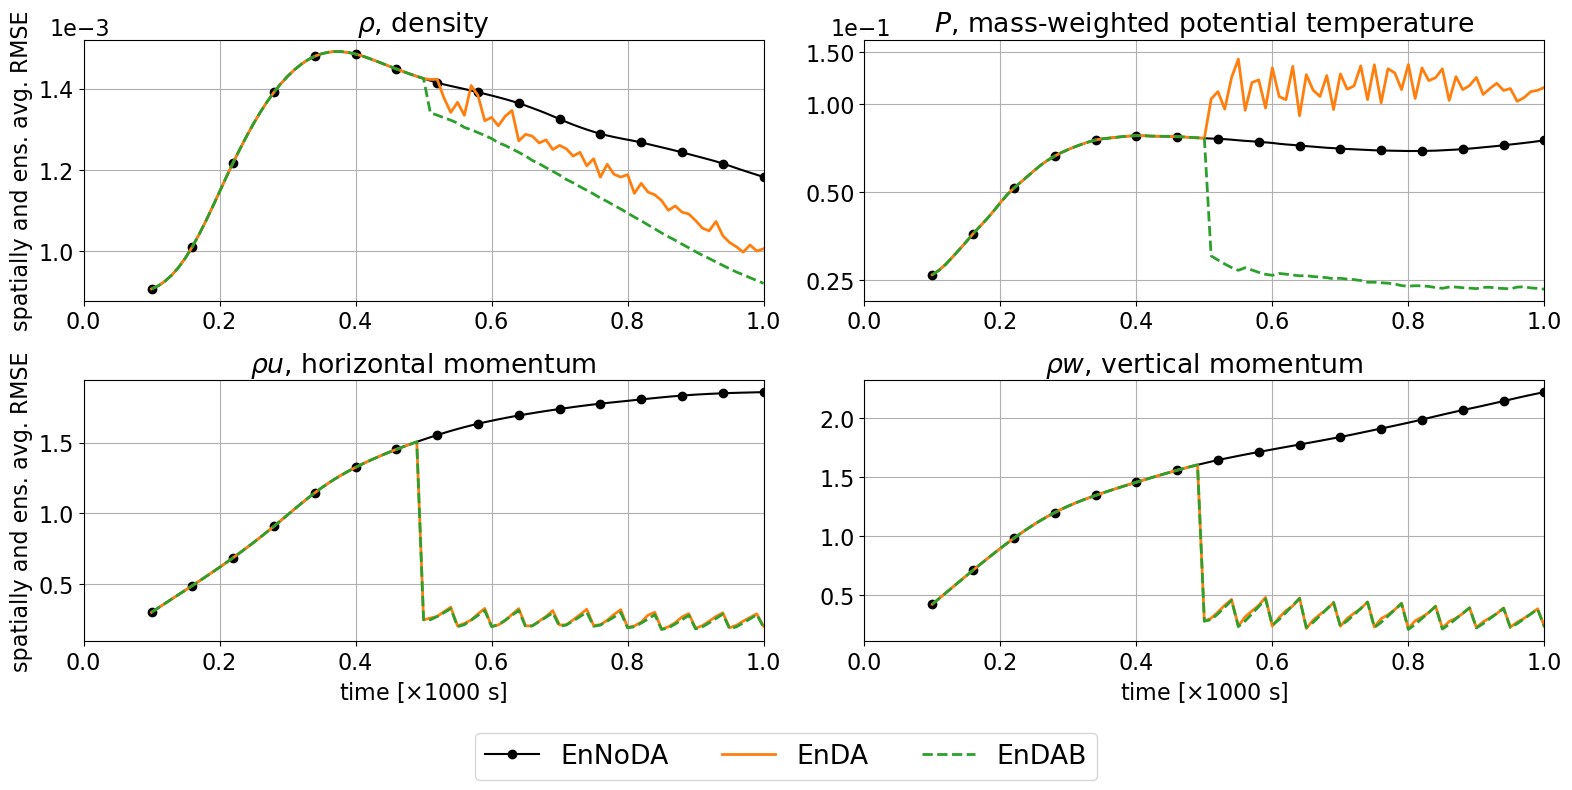

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker

plt.style.use('default')

if plot_12 == True and euler:
    fs = (16,10)
else:
    fs = (16,8)
    
nrows = 2
if MWR:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)
elif arXiv:
    pl = pt.plotter_1d(figsize=fs,fontsize=16,ncols=2,nrows=nrows)

def ic_loader(tc, N, sfx, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()

    return ud

def unitify(arr,attribute,tc,N,sfx,lbl):
    ud = ic_loader(tc,N,sfx,lbl)
    if swe:
        if attribute == 'rho' or attribute == 'p2_nodes':
            arr *= ud.h_ref
        if attribute == 'rhou' or attribute == 'rhow':
            arr *= ud.h_ref * ud.u_ref
    else:
        if attribute == 'rho':
            arr *= ud.rho_ref
        if attribute == 'rhou' or attribute == 'rhov':
            arr *= ud.rho_ref * ud.u_ref
        if attribute == 'rhoY':
            arr *= ud.rho_ref * ud.T_ref
        
    if attribute == 'p2_nodes':
        arr *= ud.Msq
    return arr
    

def get_ens(sfx,attribute,lbl,diff=False):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type='TIME', avg=False, diff=diff)[1:]
    if swe:
        ens = ens[:,:,0,:]
        
    ens = unitify(ens, attribute, tc, N, sfx, lbl)
        
    return ens

for i,attribute in enumerate(attributes):
    gt = 'n' if attribute == 'p2_nodes' else 'c'
    
    ens_noda = get_ens(ens_noda_suffix,attribute,lbl)
    if plot_oneda: ens_oneda = get_ens(ens_oneda_suffix,attribute,lbl)
    if plot_psinc: ens_psinc = get_ens(ens_psinc_suffix,attribute,lbl)
    if plot_12:
        ens_1 = get_ens(ens_1_suffix,attribute,lbl)
        ens_2 = get_ens(ens_2_suffix,attribute,lbl)

    if euler:
        ens_3 = get_ens(ens_3_suffix,attribute,lbl)
        if plot_dab: ens_4 = get_ens(ens_4_suffix,attribute,lbl)

    truth = tc.get_ensemble(times, 1, attribute, 'truth%s' %aux_ref, label_type='TIME',avg=True)[1:]
#     truth = tc.get_ensemble(times, 1, attribute, 'obs', label_type='TIME',avg=True)[1:]
    if swe: truth = truth[:,:,0,:]
    truth = unitify(truth, attribute, tc, 1, 'truth%s' %aux_ref,lbl)
#     truth = unitify(truth, attribute, tc, 1, 'obs',lbl)

    ax = pl.get_ax(i)
    avg = False

    diff_noda = tc.spatially_averaged_rmse(ens_noda,truth,avg=avg,grid_type=gt)
    if plot_oneda: diff_oneda = tc.spatially_averaged_rmse(ens_oneda,truth,avg=avg,grid_type=gt)
    if plot_psinc: diff_psinc = tc.spatially_averaged_rmse(ens_psinc,truth,avg=avg,grid_type=gt)
    if plot_12:
        diff_ens_1 = tc.spatially_averaged_rmse(ens_1,truth,avg=avg,grid_type=gt)
        diff_ens_2 = tc.spatially_averaged_rmse(ens_2,truth,avg=avg,grid_type=gt)
    if euler:
        diff_ens_3 = tc.spatially_averaged_rmse(ens_3,truth,avg=avg,grid_type=gt)
        if plot_dab: diff_ens_4 = tc.spatially_averaged_rmse(ens_4,truth,avg=avg,grid_type=gt)
#     ax.set_ylabel('spatial and ens. averaged RMSE')
#     if swe:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center', labelpad=5)
#     else:
#         ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center')
    
    if 'psinc' in pydir:
        oneda_color = 'C1--'
        l4_color = 'C1-x'
    elif 'artigen' in aux:
        l4_color = 'C1--'
        l5_color = 'C2--x'
        oneda_color = 'k--^'
    elif rb:
        l2_color = 'C1'
        l3_color = 'C2--'
    elif 'fixcov' in aux:
        l4_color = 'C1-'
        l5_color = 'C2--X'
    else:
        oneda_color = 'k--D'
        l2_color = 'C1'
        l3_color = 'C2-x'
        l4_color = 'C1--'
        l5_color = 'C2--x'
        
    if plot_psinc:
        psinc_color = 'C1-x'
    
    l1 = ax.plot(times,diff_noda, 'k-o', lw=1.5, markevery=6, label=ens_noda_label)
    if attribute == 'p2_nodes' or attribute == 'rhoY':
        semilogy = True
    else:
        semilogy = False
        
    if plot_oneda: 
        if semilogy:
            l0 = ax.semilogy(times, diff_oneda, oneda_color, markevery=10, mew=2.0, label=ens_oneda_label)
        else:
            l0 = ax.plot(times,diff_oneda,oneda_color, markevery=10, mew=2.0, label=ens_oneda_label)
    if plot_psinc: 
        if semilogy:
            lp = ax.semilogy(times, diff_psinc, psinc_color, markevery=10, mew=2.0, label=ens_oneda_label)
        else:
            lp = ax.plot(times, diff_psinc, psinc_color, markevery=10, mew=2.0, label=ens_oneda_label)
        
    if plot_12:
        if semilogy:
            l2 = ax.semilogy(times,diff_ens_1, l2_color, lw=2.0, label=ens_1_label)
            l3 = ax.semilogy(times,diff_ens_2, l3_color, lw=2.0, markevery=3, mew=2.0, label=ens_2_label)
        else:
            l2 = ax.plot(times,diff_ens_1, l2_color, lw=2.0, label=ens_1_label)
            l3 = ax.plot(times,diff_ens_2, l3_color, lw=2.0, markevery=3, mew=2.0, label=ens_2_label)
    if euler:
        if semilogy:
            l4 = ax.semilogy(times,diff_ens_3, l4_color, lw=2.0, markevery=8, mew=2.0, label=ens_3_label)
            if plot_dab: l5 = ax.semilogy(times,diff_ens_4, l5_color, lw=2.0, markevery=8, mew=2.0, label=ens_4_label)
        else:
            l4 = ax.plot(times,diff_ens_3, l4_color, lw=2.0, markevery=8, mew=2.0, label=ens_3_label)
            if plot_dab: l5 = ax.plot(times,diff_ens_4, l5_color, lw=2.0, markevery=8, mew=2.0, label=ens_4_label)
            
    

    ax.set_title("%s" %attr_labels[attribute])
    ax.set_xlim([0.0,times[-1]])
    print(attribute, ax.get_ylim())
    
    formatter = ticker.ScalarFormatter()
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    
    if 'lconv_DET' in aux:
        if attribute == 'rhou' or attribute == 'rhov':
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if attribute == 'rhoY':
            ax.yaxis.set_major_formatter(formatter) 
            ax.yaxis.set_minor_formatter(formatter) 
            ax.get_yaxis().get_offset_text().set_position((-0.05,1))
            pos = np.array([0.5,1.0,2.0,3.0,4.0]) * 1e-4
            y_locator = FixedLocator(pos)
            ax.yaxis.set_minor_locator(y_locator)
            ax.grid(which='both')
        else:
            ax.grid()
    if plot_psinc:
        if attribute == 'rhou' or attribute == 'rhov':
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        if attribute == 'p2_nodes':
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        ax.grid()
    if 'psinc' in pydir:
        if attribute == 'rhou' or attribute == 'rhov':
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        if attribute == 'p2_nodes':
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        ax.grid()
    if plot_12 and euler:
        if attribute == 'rho' or attribute == 'rhoY':
            ax.yaxis.set_major_formatter(formatter)
            ax.get_yaxis().get_offset_text().set_position((-0.05,1.1))
            if attribute == 'rhoY':
                pos = np.array([0.005,0.01,0.1,1.0]) * 1e1
                y_locator = FixedLocator(pos)
                ax.yaxis.set_major_locator(y_locator)
        else:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.grid()
    if plot_12 and rb:
        if attribute == 'rho' or attribute == 'rhoY':
            ax.yaxis.set_major_formatter(formatter)
            ax.get_yaxis().get_offset_text().set_position((-0.05,1.1))
            if attribute == 'rhoY':
#                 pos = np.array([2.5,4.0,6.0,8.0]) * 1e-2
                pos = np.array([0.25,0.5,1.0,1.5]) * 1e-1
                y_locator = FixedLocator(pos)
                ax.set_ylim([ax.get_ylim()[0],ax.get_ylim()[1]+0.01])
                ax.yaxis.set_major_locator(y_locator)
                ax.yaxis.set_minor_locator(FixedLocator([]))
        else:
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.grid()

    
    plt.tight_layout(rect=[-0.0, -0.0, 1.0, 1.0])
    
    if MWR:
        if attribute == 'rho':
            ax.set_ylabel("spatially and ens. avg. RMSE")
#             ax.set_ylabel("relative error")
        elif attribute == 'rhou':
            ax.set_ylabel("spatially and ens. avg. RMSE")
#             ax.set_ylabel("relative error")
    elif arXiv:
        if attribute == 'rho':
            ax.set_ylabel("RMSE")
        elif attribute == 'rhou':
            ax.set_ylabel("RMSE")
    if euler:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 100$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 100$ s]')
    elif rb:
        if attribute == 'rhou':
            ax.set_xlabel(r'time [$\times 1000$ s]')
        elif attribute == 'rhov':
            ax.set_xlabel(r'time [$\times 1000$ s]')
    
if euler:
    pl.fig.tight_layout()
    if MWR:
        pl.fig.subplots_adjust(bottom=0.18)
    elif arXiv:
        pl.fig.subplots_adjust(bottom=0.22)
        
    if 'psinc' in pydir:
        graphs=(l1, l0, l4)
        labels=(ens_noda_label, ens_oneda_label, 'EnDA (psinc)')
        ncol = 3
    elif 'artigen' in aux or 'lconv_DET' in aux:
        graphs = (l1, l0, l4, l5)
        labels=('EnNoDA','EnOneDA',r'EnDA $\{ \rho, \rho u, \rho w, P, \pi \}$', r'EnDAB $\{ \rho, \rho u, \rho w, P, \pi \}$')
        ncol=5        
    elif plot_12 == False:
        graphs = (l1, l4, l5)
        labels = ('EnNoDA',r'EnDA $\{ \rho, \rho u, \rho w, P, \pi \}$', r'EnDAB $\{ \rho, \rho u, \rho w, P, \pi \}$')
        ncol=3
    else:
        graphs = (l1, l2, l3, l4, l5)
        labels = ('EnNoDA', r'EnDA $\{ \rho u, \rho w \}$', r'EnDAB $\{ \rho u, \rho w \}$',r'EnDA $\{ \rho, \rho u, \rho w, P, \pi \}$', r'EnDAB $\{ \rho, \rho u, \rho w, P, \pi \}$')
        ncol = 3
        
    if plot_psinc:
        graphs = (l1, l0, lp, l4, l5)
        labels=('EnNoDA','EnOneDA', 'EnDA (psinc)', r'EnDA (comp)', r'EnDAB')
        ncol=5

    pl.fig.legend(graphs, 
                  labels=labels, 
                  ncol=ncol,
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.01, 0.0, 0.0),
                  fontsize='large'
                 )
    
if rb:
    pl.fig.tight_layout()
    pl.fig.subplots_adjust(bottom=0.18)
    pl.fig.legend([l1,l2,l3], 
                  labels=['EnNoDA', 'EnDA', 'EnDAB'], 
                  ncol=3,
                  loc='lower center',
                  bbox_to_anchor=(0.5, -0.01, 0.0, 0.0),
                  fontsize='large'
                 )
    
# plt.tight_layout()
plt.savefig('./output/%sRmse_%s.pdf' %(lbl,aux), bbox_inches="tight")
plt.show()

## Plot the ensemble members

[0.0]
9
0 0.5000623 1.1645887
1 0.50134784 1.1639224
2 0.5498322 1.106118
3 0.5000623 1.1645887
4 0.50134784 1.1639224
5 0.5498322 1.106118
6 0.5000623 1.1645887
7 0.50134784 1.1639224
8 0.5498322 1.106118


/home/ray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:212: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
../plotting_tools.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.arr_lst = np.array(arr_lst)


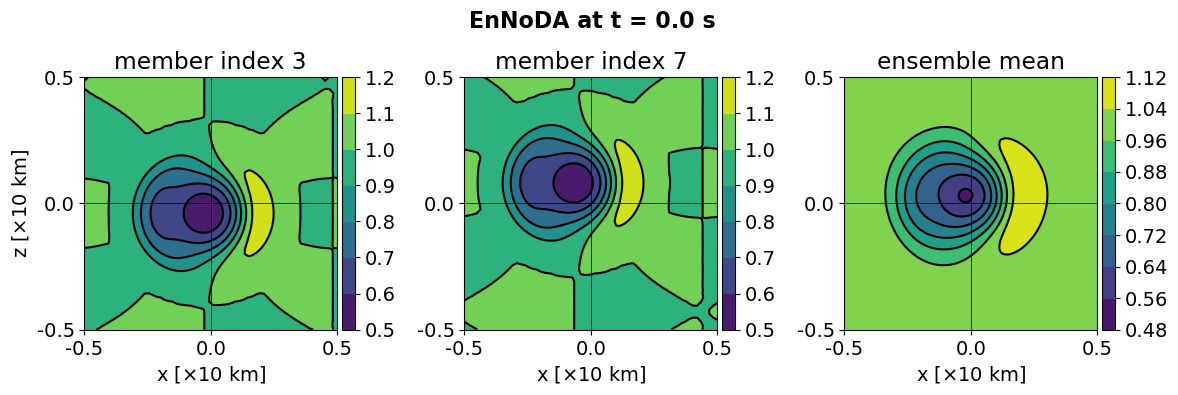

In [95]:
# plot pressure / water depth perturbation
attributes = ['p2_nodes']
attributes = ['rhov']

# plot the very last output
ens_time = [times[-1]]
ens_time = [0.0]
times = ens_time
print(ens_time)
tag = tags[9]
tag = 'ic'

class oo(object): pass
ens0_oo = oo()
ens1_oo = oo()
ens_ref_oo = oo()

if euler:
    ens_1_suffix = ens_3_suffix
    ens_2_suffix = ens_3_suffix

if len(attributes) > 1:
    # for plotting of derived quantities, e.g. u,v,w, and Theta.
    for attribute in attributes:
        ens0 = tc.get_ensemble(times, N, attribute, ens_1_suffix, tag=tag, inner=True)[-1]
        ens1 = tc.get_ensemble(times, N, attribute, ens_2_suffix, tag=tag, inner=True)[-1]
        ens_ref = tc.get_ensemble(times, N, attribute, ens_noda_suffix, tag=tag, inner=True)[-1]
        setattr(ens0_oo,attribute,ens0)
        setattr(ens1_oo,attribute,ens1)
        setattr(ens_ref_oo,attribute,ens_ref)

    ens0 = getattr(ens0_oo,attributes[1]) / getattr(ens0_oo,attributes[0])
    ens1 = getattr(ens1_oo,attributes[1]) / getattr(ens1_oo,attributes[0])
    ens_ref = getattr(ens_ref_oo,attributes[1]) / getattr(ens_ref_oo,attributes[0])
else:
    ens0 = tc.get_ensemble(times, N, attributes[0], ens_1_suffix, tag=tag, inner=True)[-1]
    ens1 = tc.get_ensemble(times, N, attributes[0], ens_2_suffix, tag=tag, inner=True)[-1]
    ens_ref = tc.get_ensemble(times, N, attributes[0], ens_noda_suffix, tag=tag, inner=True)[-1]
    
    ens0_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_1_suffix, tag=tag, inner=True)[-1]
    ens1_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_2_suffix, tag=tag, inner=True)[-1]
    ens_ref_rhoY = tc.get_ensemble(times, N, 'rhoY', ens_noda_suffix, tag=tag, inner=True)[-1]
    
def p_converter(ens,rhoY,ud):
    dp2n = np.array([ (mem - mem.mean()) * ud.Msq for mem in ens ])
    kernel = np.ones((2,2))
    dp2c = np.array([signal.fftconvolve(mem, kernel, mode='valid') / kernel.sum() for mem in dp2n])

    P0 = (rhoY**(ud.gamm-1.0) - dp2c)**(1.0/(ud.gamm-1.0))
    p = rhoY**(ud.gamm) - P0**(ud.gamm)
    p *= ud.p_ref
    return p


def ic_loader(tc, sfx, lbl):
    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx,format='dat')
    path_pickle = tc.get_path(fn_pickle)

    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    file.close()
    
#     if lbl == 'swe':
#         p_ref = ud.h_ref * ud.Msq
#     elif lbl == 'euler':
#         p_ref = ud.p_ref * ud.Msq
#     elif lbl =='rb':
#         p_ref = ud.p_ref * ud.Msq

#     return p_ref
    return ud

ud = ic_loader(tc,ens_1_suffix,lbl)

# ens_ref = p_converter(ens_ref, ens_ref_rhoY, ud)
# ens0 = p_converter(ens0, ens0_rhoY, ud)
# ens1 = p_converter(ens1, ens1_rhoY, ud)

enses = [ens_ref, ens0, ens1]
sfxes = [ens_noda_suffix, ens_1_suffix, ens_2_suffix]

if swe:
    mean0 = np.mean(ens0,axis=0)[:,0,:] 
    mean1 = np.mean(ens1,axis=0)[:,0,:]
    mean_ref = np.mean(ens_ref,axis=0)[:,0,:]
else:
    mean0 = np.mean(ens0,axis=0)
    mean1 = np.mean(ens1,axis=0)
    mean_ref = np.mean(ens_ref,axis=0)

diff = False
if diff == True:
    mean0 -= mean_ref
    mean1 -= mean_ref

if MWR:
    mean0 = [mean0.T,'']
    mean1 = [mean1.T,'']
    mean_ref = [mean_ref.T,'ensemble mean']
elif arXiv:
    mean0 = [mean0.T,'']
    mean1 = [mean1.T,'']
    mean_ref = [mean_ref.T,'ensemble mean']
means = [mean_ref, mean0, mean1]

arr_lst = []
lvls = []
ens_store, ens_diff = [], []
for bb,ens in enumerate(enses):
    sfx = sfxes[bb]
    fs = (14,8)
        
    ens_arr = []
    for n,arr in enumerate(ens):
        arr_ref = ens_ref[n]
        if swe:
            arr_ref = arr_ref[:,0,:].T
            arr = arr[:,0,:].T
        else:
            arr_ref = arr_ref.T
            arr = arr.T

        if diff == True:
            arr -= arr_ref
            
        if rb:
            if bb == 1:
                ens_store.append(arr)
            if bb == 2:
                if MWR:
                    ens_diff.append([ens_store[n] - (arr), ''])
                elif arXiv:
                    ens_diff.append([ens_store[n] - (arr), ''])
        
        if bb == 0:
            if MWR:
                ens_arr.append([arr, 'member index %i' %n])
            elif arXiv:
                ens_arr.append([arr, 'member index %i' %n])
        else:
            ens_arr.append([arr, ''])
            

    # which members to plot?
    arr_lst += [ens_arr[3],ens_arr[7]]
#     arr_lst += [ens_arr[0],ens_arr[1],ens_arr[2],ens_arr[3],ens_arr[4],ens_arr[5],ens_arr[6],ens_arr[7],ens_arr[8],ens_arr[9]]
    # append mean to plot
    arr_lst.append(means[bb])

    if rb:
        # exner levels
#         if bb == 0:
#             lvls += [np.arange(-50,40,10)]*4
#         elif bb == 1:
#             lvls += [np.arange(-70,60,20)]*4
#         elif bb == 2:
#             lvls += [np.arange(-50,40,10)]*4
        # pressure levels
        if bb == 0:
            lvls += [np.arange(-100,60,20)]*3
        elif bb == 1:
#             lvls += [np.arange(-70,60,20)]*4
            lvls += [np.arange(-160,120,40)]*3
        elif bb == 2:
#             lvls += [np.arange(-50,40,10)]*4
            lvls += [np.arange(-100,60,20)]*3
            
        
    if euler:
#         # exner levels
#         if bb == 0:
#             lvls += [np.arange(-55,15,10)]*4
#         elif bb == 1:
#             lvls += [np.arange(-550.0,650.0,150.0)]*4
#         elif bb == 2:
#             lvls += [np.arange(-70,10,10)]*4
        # pressure levels
        if bb == 0:
            lvls += [np.arange(-200,40,40)]*3
        elif bb == 1:
#             lvls += [np.arange(-550.0,650.0,150.0)]*4
            lvls += [np.arange(-1900,1300+640,640)]*3
        elif bb == 2:
            lvls += [np.arange(-200,40,40)]*3
    
if rb:
    # which member-diffs to plot?
    arr_lst += [ens_diff[3],ens_diff[7]]
    # append mean to plot
    if MWR:
        mean_diff = [means[1][0] - means[2][0], '']
    elif arXiv:
        mean_diff = [means[1][0] - means[2][0], '']
    arr_lst.append(mean_diff)
#     lvls += [np.arange(-30,50,10)]*4 # exner levels
    lvls += [np.arange(-80,130,30)]*4 # pressure levels
print(len(lvls))

for idx, arr in enumerate(arr_lst):
    if idx % 4 == 0:
        print("===========")
    print(idx, arr[0].min(),arr[0].max())

# if attributes[0] == 'p2_nodes':
#     nnx, nnz = axs0, axs1
#     axh, axv = 32, 32
# else:
nnx, nnz = axs0-1,axs1-1
    
arr_lst = arr_lst[:3]
narr_lst = np.array(arr_lst)
ncolslen = 3
if MWR:
#     fs = (15,11) if rb else (12,11)
    fs = (15,11) if rb else (12,4)
elif arXiv:
    fs = (18,9) if rb else (13,7)
pl = pt.plotter(arr_lst,ncols=ncolslen,figsize=fs,sharexlabel=True,shareylabel=True)

x_label = r'x [$\times 10$ km]'
y_label = r'z [$\times 10$ km]'

if rb:
    x_loc = np.linspace(0,nnx,5)
    y_loc = np.linspace(0,nnz,3)
    axh, axv = 39.5, 79.5
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
#     pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, axhline = axh, axvline = axv, x_label=x_label, y_label=y_label)
else:
    x_loc = np.linspace(0,nnx,3)
    y_loc = np.linspace(0,nnz,3)
    axh, axv = 31.5, 31.5
    pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, axhline = axh, axvline = axv, x_label=x_label, y_label=y_label)

if rb:
    pl.img.figtext(0.4650,0.975,"EnNoDA", fontfamily='sans-serif', fontsize=16, fontweight='bold')
    pl.img.figtext(0.4775,0.715,"EnDA", fontfamily='sans-serif', fontsize=16, fontweight='bold')
    pl.img.figtext(0.4705,0.480,"EnDAB", fontfamily='sans-serif', fontsize=16, fontweight='bold')
    pl.img.figtext(0.3490,0.255,"difference between EnDA and EnDAB", fontfamily='sans-serif', fontsize=16, fontweight='bold')
else:
#     pl.img.figtext(0.45,0.975,"EnNoDA at t = %.3f" %ens_time[0], fontfamily='sans-serif', fontsize=16, fontweight='bold')
    pl.img.figtext(0.40,0.975,"EnNoDA at t = %.1f s" %(ens_time[0]*100), fontfamily='sans-serif', fontsize=16, fontweight='bold')
#     pl.img.figtext(0.465,0.645,"EnDA", fontfamily='sans-serif', fontsize=16, fontweight='bold')
#     pl.img.figtext(0.455,0.335,"EnDAB", fontfamily='sans-serif', fontsize=16, fontweight='bold')
#     pl.img.figtext(0.36,0.335,"EnDA (comp) at t = %.1f s" %(ens_time[0]*100), fontfamily='sans-serif', fontsize=16, fontweight='bold')
#     pl.img.figtext(0.365,0.645,"EnDA (psinc) at t = %.1f s" %(ens_time[0]*100), fontfamily='sans-serif', fontsize=16, fontweight='bold')

# mthd = 'imshow' if rb else 'contour'
mthd = 'contour'
_ = pl.plot(aspect='equal',method=mthd, lvls=None)

pl.save_fig('./output/%sEnses' %lbl)